In [ ]:
MODEL_PATH      = "SAM_models/sam_vit_b_01ec64.pth"
IMAGE_PATH      = "Images/Original_Img.jpg"
STROKES_PATH    = "Images/Strokes.json" 
TREND_PATH      = "Images/Trend.jpg"
CNN_PATH        = "Images/CNN_Img.jpg"

import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision.transforms import functional as F
from    skimage.measure import label

In [ ]:
# Step 1: Full image automatic masks detection

# Load image using OpenCV (BGR)
image = cv2.imread(IMAGE_PATH)

# Convert to RGB for PyTorch model input
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to tensor
image_tensor = F.to_tensor(image_rgb).unsqueeze(0)  # shape: [1, 3, H, W]

# Load Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Inference
with torch.no_grad():
    prediction = model(image_tensor)[0]

# Extract and binarize masks
masks = prediction['masks'].cpu().numpy()         # shape: [N, 1, H, W]
# masks = (masks > 0.5).astype(np.uint8)
# masks = masks[:, 0]                               # shape: [N, H, W]


C:\Users\Hoan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hoan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
# Visualize results
for i in range(len(prediction['boxes'])):
    score = prediction['scores'][i].item()
    if score < 0.7:  # confidence threshold
        continue

    box = prediction['boxes'][i].cpu().numpy().astype(int)
    label = prediction['labels'][i].item()
    mask = prediction['masks'][i, 0].cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8)

    # Apply mask to image
    color = np.random.randint(0, 255, (3,), dtype=int).tolist()
    colored_mask = np.zeros_like(cv_image)
    for c in range(3):
        colored_mask[:, :, c] = mask * color[c]
    cv_image = cv2.addWeighted(cv_image, 1, colored_mask, 0.5, 0)

    # Draw bounding box
    cv2.rectangle(cv_image, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(cv_image, f"Label: {label}", (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Resize image to fit screen if it's too large
max_height = 800
scale = max_height / cv_image.shape[0]
new_width = int(cv_image.shape[1] * scale)
resized_image = cv2.resize(cv_image, (new_width, max_height))

cv2.imshow("Mask R-CNN", resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
# Step 2: User mask-processing

img_height, img_width   = image.shape[:2]

print(f"[INFO] Loaded image: {IMAGE_PATH}")
print(f"[INFO] Image size: height={img_height}, width={img_width}")

# Prepare blank mask
user_mask = np.zeros((img_height, img_width), dtype=np.uint8)

# Load strokes
with open(STROKES_PATH, "r") as f:
    strokes_data = json.load(f)

# Draw strokes on mask
for stroke in strokes_data:
    points = np.array([[int(p["x"]), int(p["y"])] for p in stroke["points"]], dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.fillPoly(user_mask, [points], color=1)

# Optionally fill
user_mask = cv2.dilate(user_mask, np.ones((3, 3), np.uint8), iterations=1)
user_mask = cv2.morphologyEx(user_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
user_mask = (user_mask > 0).astype(np.uint8)

print(f"[INFO] User mask size: {user_mask.shape}")
print(f"[INFO] User mask non-zero pixels: {np.count_nonzero(user_mask)}")

[INFO] Loaded image: Images/Original_Img.jpg
[INFO] Image size: height=1536, width=2048
[INFO] User mask size: (1536, 2048)
[INFO] User mask non-zero pixels: 171959


In [39]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

In [ ]:
min_iou_threshold = 0.5
matched_count = 0
all_ious = []

for user_index, user_mask1 in enumerate(user_mask):  # <-- multiple user masks
    best_iou = 0.0
    best_match = None

    for i, pred_mask in enumerate(prediction["masks"]):
        # Convert predicted mask to binary
        mask = pred_mask[0].cpu().numpy()
        mask_binary = (mask > 0.5).astype(np.uint8)

        # Resize just in case
        if mask_binary.shape != user_mask1.shape:
            mask_binary = cv2.resize(mask_binary, (user_mask1.shape[1], user_mask1.shape[0]))

        # Compute IoU
        iou = compute_iou(user_mask1, mask_binary)

        if iou > best_iou:
            best_iou = iou
            best_match = mask_binary

    all_ious.append(best_iou)
    print(f"[INFO] User Mask {user_index}: Best IoU = {best_iou:.4f}")

    if best_iou > min_iou_threshold:
        matched_count += 1
        # Optionally: store best_match for visualization
    else:
        print(f"[WARN] User Mask {user_index} had no strong match")

# Summary
print(f"\n[RESULT] Matched {matched_count}/{len(user_mask)} user masks (IoU > {min_iou_threshold})")
print(f"[RESULT] Average IoU: {np.mean(all_ious):.4f}")



In [48]:
# Step 3: User masks vs CNN Masks

from skimage.measure import label

combined_user_mask  = np.zeros_like(user_mask)
combined_CNN_mask   = np.zeros_like(user_mask)
ious                = []

user_labeled = label(user_mask)
num_regions = np.max(user_labeled)
user_masks = [(user_labeled == i).astype(np.uint8) for i in range(1, num_regions + 1)]
print(f"[INFO] Found {num_regions} user-defined regions.")

# Convert CNN masks to binary
# Convert and clean
masks = prediction['masks'].cpu().numpy()  # [64, 1, 1536, 2048]
masks = masks[:, 0]  # Remove the singleton dim → [64, 1536, 2048]
cnn_binary_masks = (masks > 0.5).astype(np.uint8)  # Threshold

# Check mask shape again
print("Sanity check:", cnn_binary_masks.shape)  # should be [64, 1536, 2048]

for i, u_mask in enumerate(user_masks):
    best_iou = 0
    best_idx = -1
    for j, cnn_mask in enumerate(cnn_binary_masks):
        # print("CNN mask shape:", cnn_mask.shape) 
        if cnn_mask.shape != u_mask.shape:
            cnn_mask = cv2.resize(cnn_mask, (u_mask.shape[1], u_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # assert cnn_mask.shape == u_mask.shape, f"Shape mismatch: {cnn_mask.shape} vs {u_mask.shape}"
        iou = compute_iou(u_mask, cnn_mask)
        if iou > best_iou:
            best_iou = iou
            best_idx = j

    if best_idx == -1:
        print(f"[WARN] No matching CNN mask found for user region {i}")
        continue

    best_cnn = cnn_binary_masks[best_idx]
    combined_user_mask = np.logical_or(combined_user_mask, u_mask)
    combined_CNN_mask  = np.logical_or(combined_CNN_mask, best_cnn)
    ious.append(best_iou)

avg_iou = sum(ious) / len(ious) if ious else 0
print(f"[INFO] Average IoU: {avg_iou:.4f}")


[INFO] Found 2 user-defined regions.
Sanity check: (64, 1536, 2048)
[INFO] Average IoU: 0.7170


In [44]:
print("[DEBUG] Original mask shape:", prediction['masks'].shape)
print("[DEBUG] Numpy mask shape:", masks.shape)

print("User mask shape:", user_mask.shape)
print("CNN mask shape:", cnn_binary_masks[0].shape)


[DEBUG] Original mask shape: torch.Size([64, 1, 1536, 2048])
[DEBUG] Numpy mask shape: (64, 1536, 2048)
User mask shape: (1536, 2048)
CNN mask shape: (2048,)


In [37]:
print(cnn_binary_masks)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


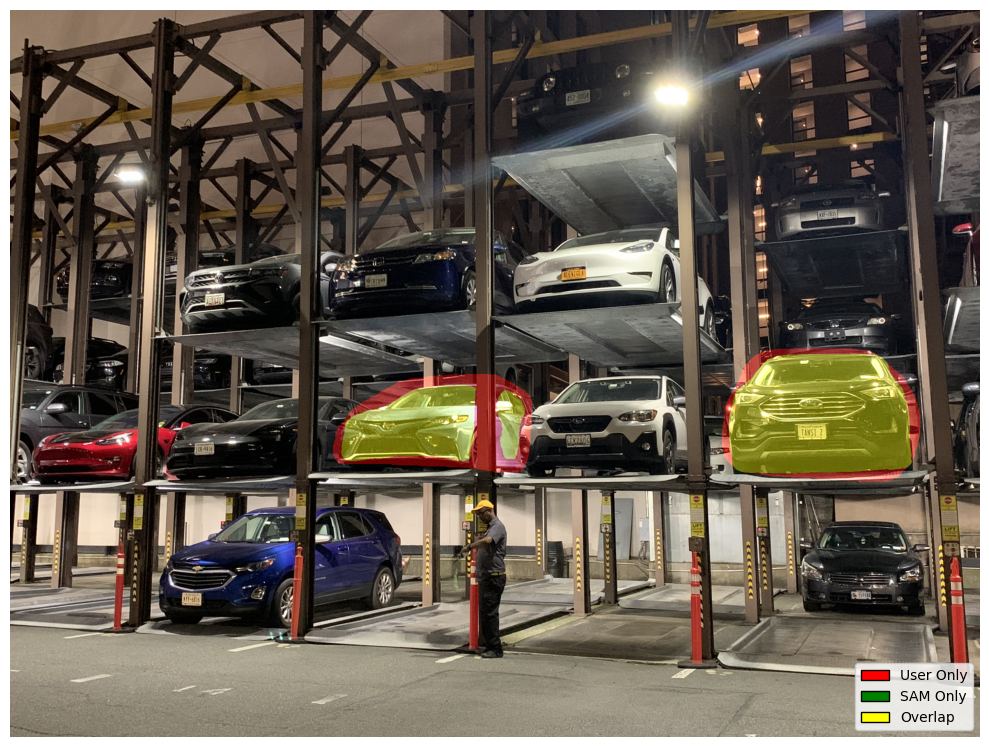

In [52]:
# Step 4: Create visualization
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Red = User only, Green = SAM only, Yellow = overlap
user_only = np.logical_and(combined_user_mask == 1, combined_CNN_mask == 0)
cnn_only  = np.logical_and(combined_user_mask == 0, combined_CNN_mask == 1)
both      = np.logical_and(combined_user_mask == 1, combined_CNN_mask == 1)

overlay_mask = np.zeros_like(image)
overlay_mask[user_only] = [255, 0, 0]     # Red
overlay_mask[cnn_only]  = [0, 255, 0]     # Green
overlay_mask[both]      = [255, 255, 0]   # Yellow

# Blend with original image
alpha = 0.4
final_overlay = cv2.addWeighted(image, 1.0, overlay_mask, alpha, 0)
plt.figure(figsize=(10, 8))
plt.imshow(final_overlay)
plt.axis("off")

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red',   edgecolor='black', label='User Only'),
    Patch(facecolor='green', edgecolor='black', label='SAM Only'),
    Patch(facecolor='yellow',edgecolor='black', label='Overlap'),
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()
# plt.savefig(CNN_PATH, bbox_inches='tight', pad_inches=0)
plt.show()

